<a href="https://colab.research.google.com/github/jwang44/upgraded-octo-chainsaw/blob/main/Load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chainsaw

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/imageunderstanding'

/content/drive/MyDrive/imageunderstanding


In [3]:
!ls

ExampleSubmissionRandom.csv  Test.pkl	       Train.pkl
LoadData.ipynb		     Train_labels.csv


In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torch

In [41]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Visualize some images (can skip)

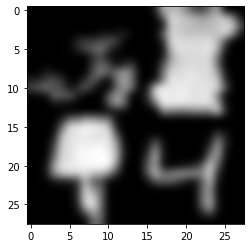

In [21]:
# Read a pickle file and display its samples
data = pickle.load( open( 'Train.pkl', 'rb' ))
targets = np.genfromtxt('Train_labels.csv', delimiter=',', skip_header=1, usecols=1)
# data = np.squeeze(data,axis=1)
plt.imshow(data[2][0], cmap='gray', interpolation="bicubic")
plt.show()

In [22]:
print("data_shape: ", data.shape)
print("targets_shape: ", targets.shape)

data_shape:  (60000, 1, 28, 28)
targets_shape:  (60000,)


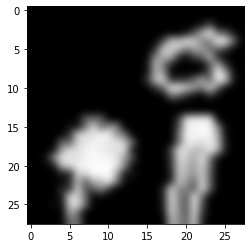

In [24]:
plt.imshow(data[1930][0], cmap='gray', interpolation="bicubic")
plt.show()



## Load data

In [5]:
# Read image data and their label into a Dataset 
data = pickle.load( open( 'Train.pkl', 'rb' ))
# this line is changed to 
# 1. make sure data and targets are of the same dimension
# 2. drop the index column
targets = np.genfromtxt('Train_labels.csv', delimiter=',', skip_header=1, usecols=1)

data = torch.from_numpy(data)
targets = torch.from_numpy(targets)

dataset = TensorDataset(data,targets)

In [6]:
print("data_shape: ", data.shape)
print("target_shape: ", targets.shape)
print("dataset_size: ", len(dataset))

data_shape:  torch.Size([60000, 1, 28, 28])
target_shape:  torch.Size([60000])
dataset_size:  60000


Split dataset into train and val: train_loader/val_loader

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

In [8]:
batch_size = 256
val_split = 0.2
shuffle = True

# Creating indices for train and val split:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(val_split * dataset_size))
if shuffle:
  # set random seed so that we get the same split everytime
  np.random.seed(0)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

torch.Size([256, 1, 28, 28])
torch.Size([256, 28, 28])


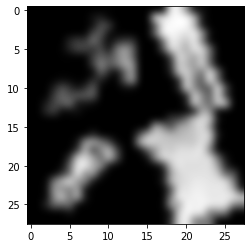

In [9]:
# Read a batch of data and their labels and display them
[imgs, labels] = (next(iter(val_loader)))
print(imgs.shape)
# imgs: [256, 1, 28, 28]
imgs = np.squeeze(imgs)
# imgs: [256, 28, 28]
print(imgs.shape)
plt.imshow(imgs[5].cpu().numpy(),cmap='gray',interpolation="bicubic") #.transpose()

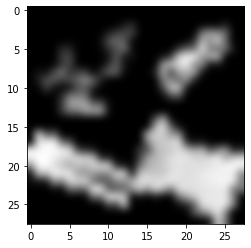

In [10]:
# maybe use transpose to augment the training data
plt.imshow(imgs[5].cpu().numpy().transpose(),cmap='gray',interpolation="bicubic")

In [ ]:
# Here is a piece of code that reads data in batch.
# In each epoch all samples are read in batches using dataloader

num_epochs=2 # Feel free to change it
for epoch in range(num_epochs):
    for data in dataloader:
        [img,label] = data



## Basic NN model